In [2]:
# !pip install -q kaggle
# !mkdir -p ./kaggle
# !cp kaggle.json ./kaggle/
# !chmod 600 ./kaggle/kaggle.json
# !cat ./kaggle/kaggle.json
# ! kaggle datasets list
# !kaggle datasets download -d haqishen/rsna-cropped-2d-224-0920-2m


In [3]:
# import shutil

# # Specify the directory you want to delete
# directory_to_delete = './Dataset/segmented_dataset'


# # Delete the directory and all its contents
# shutil.rmtree(directory_to_delete)

# print("Directory deleted successfully.")

In [4]:
# !ls ./rsna-cropped-2d-224-0920-2m.zip
# # !mkdir -p ./Dataset
# !unzip ./rsna-cropped-2d-224-0920-2m.zip -d ./Dataset/lstm_dataset



In [2]:
 !pip install timm
 !pip install albumentations
 !pip install --force-reinstall albumentations
 !pip install segmentation_models_pytorch
 !pip install monai
 !pip install imageio
 !pip install pydicom
 !pip install pandas
 !pip install nibabel
 !pip install matplotlib
 !pip install torch
 !pip install cv
 !pip install pylibjpeg==1.4.0
 !pip install python_gdcm==3.0.17.1
 !pip install pylibjpeg-libjpeg
 !pip install --upgrade albumentations


  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/68/99/2018622d268f6017ddfa5ee71f070bad5d07590374793166baa102849d17/timm-0.9.16-py3-none-any.whl.metadata
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/35/3a/a39f354fa3119785be87e2f94ffa2620f8a270c8560f7356358ee62fb4c5/torch-2.3.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/6e/7d/bc67ec2d1011226e75cdcc45a2c85d97b8eaac32a7d648b71c432d584367/torchvision-0.18.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for huggingface_hub from https://files.pythonhosted.org/packages/21/2b/516f82c5ba9beb184b24c11976be2ad5e80fb7fe6b2796c887087144445e/huggingface_hub-0.23.0-py3-none-any.whl.metadata
  Obtaining dependency information for safetensors from https://files.pythonhosted.org/packages/d5/85/1e7d2804cbf82204cde462d16f1cb0ff5814b03f559fb46ceaa

In [1]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import pandas as pd
import random
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(len(os.listdir("./Dataset/seg_masks/cropped_2d_224_15_ext0_5ch_0920_2m/cropped_2d_224_15_ext0_5ch_0920_2m")))

211890


<h2>Config</h2>

In [3]:

DEBUG = False
kernel_type ='0920_1bonev2_resnet18_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
load_last = True

n_folds = 5
backbone = 'resnet18'

image_size = 224
n_slice_per_c = 15
in_chans = 6

init_lr = 23e-5
eta_min = 23e-6
batch_size = 8
drop_rate = 0.
drop_rate_last = 0.3
drop_path_rate = 0.
p_mixup = 0.5
p_rand_order_v1 = 0.2

data_dir = './Dataset/seg_masks/cropped_2d_224_15_ext0_5ch_0920_2m/cropped_2d_224_15_ext0_5ch_0920_2m'
use_amp = True
num_workers = 4
out_dim = 1

n_epochs = 10

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [4]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightnessContrast(limit=0.1, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=3),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),

    albumentations.CoarseDropout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/opt/conda/lib/python3.11/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'limit' is not valid and will be ignored.
  warn(
/opt/conda/lib/python3.11/site-packages/albumentations/augmentations/blur/transforms.py:240: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  warn(
/opt/conda/lib/python3.11/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  warn(
/opt/conda/lib/python3.11/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  warn(


<h2>Dataframe</h2>

In [5]:

df = pd.read_csv(os.path.join(f'./Dataset/seg_masks/train_seg.csv'))
df = df.sample(16).reset_index(drop=True) if DEBUG else df


sid = []
cs = []
label = []
fold = []
for _, row in df.iterrows():
    for i in [1,2,3,4,5,6,7]:
        sid.append(row.StudyInstanceUID)
        cs.append(i)
        label.append(row[f'C{i}'])
        fold.append(row.fold)

df = pd.DataFrame({
    'StudyInstanceUID': sid,
    'c': cs,
    'label': label,
    'fold': fold
})

df.tail()

,StudyInstanceUID,c,label,fold
14121,1.2.826.0.1.3680043.18786,3,0,4
14122,1.2.826.0.1.3680043.18786,4,0,4
14123,1.2.826.0.1.3680043.18786,5,0,4
14124,1.2.826.0.1.3680043.18786,6,0,4
14125,1.2.826.0.1.3680043.18786,7,1,4


In [6]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        cid = row.c
        
        images = []
        
        for ind in list(range(n_slice_per_c)):
            filepath = os.path.join(data_dir, f'{row.StudyInstanceUID}_{cid}_{ind}.npy')
            image = np.load(filepath)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)

        if self.mode != 'test':
            images = torch.tensor(images).float()
            labels = torch.tensor([row.label] * n_slice_per_c).float()
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]

            return images, labels
        else:
            return torch.tensor(images).float()

In [7]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

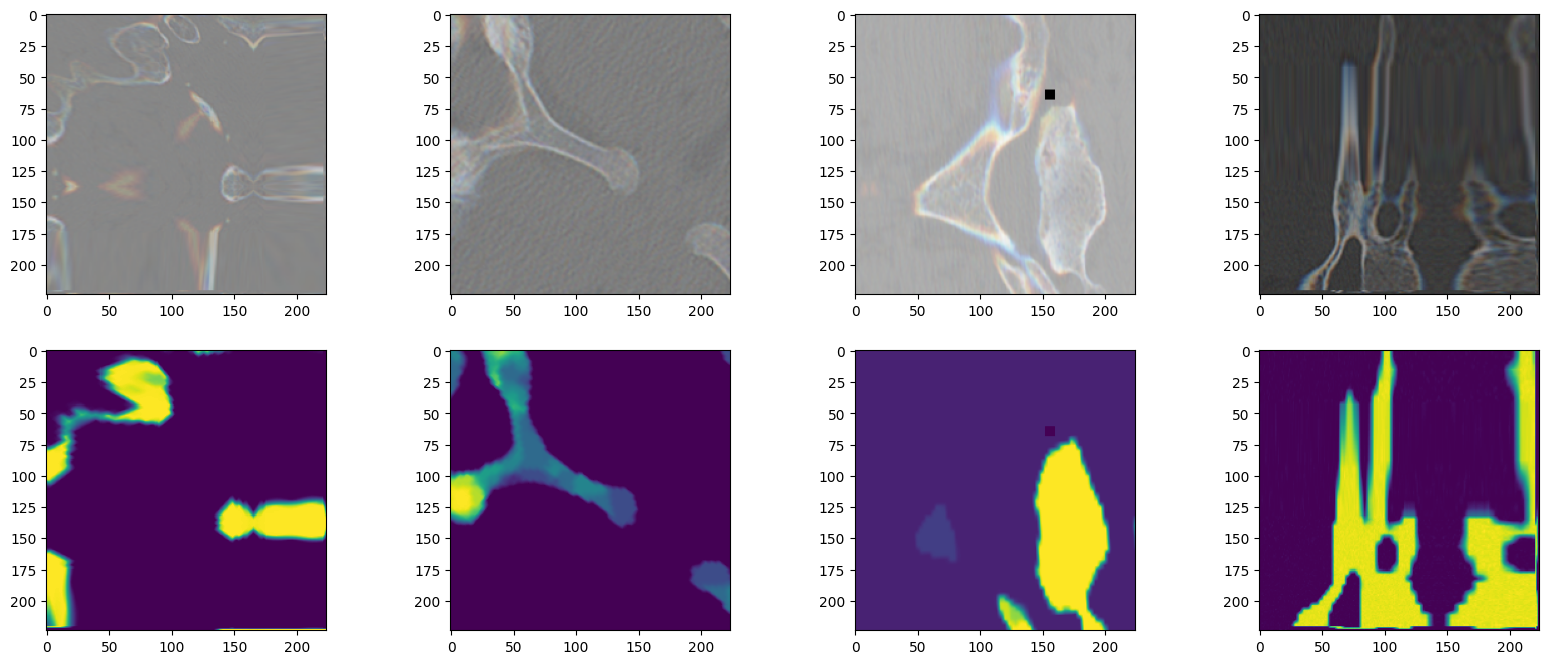

In [9]:
f, axarr = plt.subplots(2,4)
for p in range(4):
    idx = p * 20
    imgs, lbl = dataset_show[idx]
    axarr[0, p].imshow(imgs[7][:3].permute(1, 2, 0))
    axarr[1, p].imshow(imgs[7][-1])

<h2>Model</h2>

In [10]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'resnet' in backbone:
            hdim = self.encoder.fc.out_features
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
         
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c, in_chans, image_size, image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c, -1)
        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice_per_c).contiguous()
    
        return feat

In [11]:
m = TimmModel(backbone)
m(torch.rand(2, n_slice_per_c, in_chans, image_size, image_size)).shape
#print(m)

torch.Size([2, 15])

<h2>Loss & Metric</h2>

In [12]:
bce = nn.BCEWithLogitsLoss(reduction='none')


def criterion(logits, targets, activated=False):
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    norm = torch.ones(logits.view(-1).shape[0]).to(device)
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()

<h2>Train & Valid func <h2>

In [13]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        
        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    outputs = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits = model(images)
            loss = criterion(logits, targets)
            
            gts.append(targets.cpu())
            outputs.append(logits.cpu())
            valid_loss.append(loss.item())
            
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    outputs = torch.cat(outputs)
    gts = torch.cat(gts)
    valid_loss = criterion(outputs, gts).item()

    return valid_loss

/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

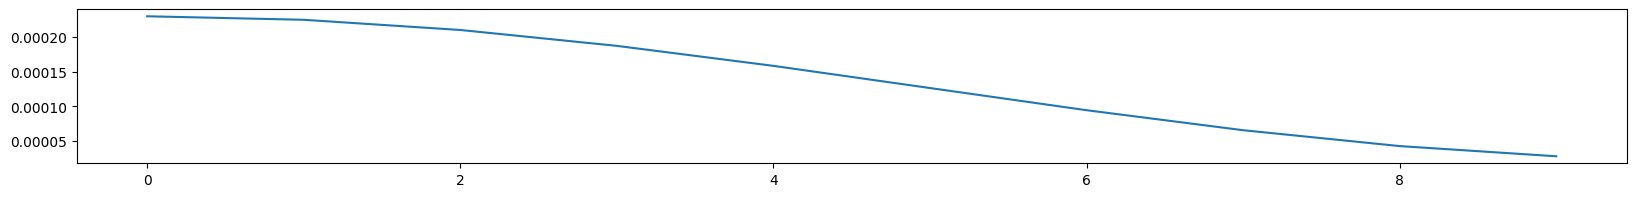

In [14]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

<h2>Training</h2>

In [15]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [16]:
run(0)


11298 2828
Wed May  8 23:46:29 2024 Epoch: 1


smth:0.8108: 100%|██████████| 354/354 [01:06<00:00,  5.29it/s]


Wed May  8 23:55:00 2024 Fold 0, Epoch 1, lr: 0.0002300, train loss: 0.45961, valid loss: 0.48193, metric: 0.481926.
metric_best (inf --> 0.481926). Saving model ...
Wed May  8 23:55:01 2024 Epoch: 2


smth:0.7021: 100%|██████████| 354/354 [01:03<00:00,  5.59it/s]


Thu May  9 00:03:29 2024 Fold 0, Epoch 2, lr: 0.0002249, train loss: 0.44560, valid loss: 0.46121, metric: 0.461212.
metric_best (0.481926 --> 0.461212). Saving model ...
Thu May  9 00:03:29 2024 Epoch: 3


smth:0.7237: 100%|██████████| 354/354 [01:06<00:00,  5.32it/s]


Thu May  9 00:12:04 2024 Fold 0, Epoch 3, lr: 0.0002102, train loss: 0.44048, valid loss: 0.45230, metric: 0.452301.
metric_best (0.461212 --> 0.452301). Saving model ...
Thu May  9 00:12:05 2024 Epoch: 4


smth:0.7264: 100%|██████████| 354/354 [01:07<00:00,  5.28it/s]


Thu May  9 00:20:40 2024 Fold 0, Epoch 4, lr: 0.0001873, train loss: 0.43618, valid loss: 0.44849, metric: 0.448489.
metric_best (0.452301 --> 0.448489). Saving model ...
Thu May  9 00:20:40 2024 Epoch: 5


smth:0.7161: 100%|██████████| 354/354 [01:05<00:00,  5.39it/s]


Thu May  9 00:29:18 2024 Fold 0, Epoch 5, lr: 0.0001585, train loss: 0.43122, valid loss: 0.43602, metric: 0.436024.
metric_best (0.448489 --> 0.436024). Saving model ...
Thu May  9 00:29:18 2024 Epoch: 6


smth:0.7619: 100%|██████████| 354/354 [01:06<00:00,  5.32it/s]


Thu May  9 00:37:57 2024 Fold 0, Epoch 6, lr: 0.0001265, train loss: 0.42261, valid loss: 0.44131, metric: 0.441306.
Thu May  9 00:37:57 2024 Epoch: 7


smth:0.7546: 100%|██████████| 354/354 [01:06<00:00,  5.28it/s]


Thu May  9 00:46:37 2024 Fold 0, Epoch 7, lr: 0.0000945, train loss: 0.41269, valid loss: 0.45010, metric: 0.450099.
Thu May  9 00:46:37 2024 Epoch: 8


smth:0.6859: 100%|██████████| 354/354 [01:07<00:00,  5.22it/s]


Thu May  9 00:55:19 2024 Fold 0, Epoch 8, lr: 0.0000657, train loss: 0.40563, valid loss: 0.40842, metric: 0.408419.
metric_best (0.436024 --> 0.408419). Saving model ...
Thu May  9 00:55:19 2024 Epoch: 9


smth:0.7562: 100%|██████████| 354/354 [01:05<00:00,  5.37it/s]


Thu May  9 01:03:56 2024 Fold 0, Epoch 9, lr: 0.0000428, train loss: 0.39611, valid loss: 0.41425, metric: 0.414251.
Thu May  9 01:03:56 2024 Epoch: 10


smth:0.7859: 100%|██████████| 354/354 [01:06<00:00,  5.32it/s]


Thu May  9 01:12:33 2024 Fold 0, Epoch 10, lr: 0.0000281, train loss: 0.39054, valid loss: 0.42519, metric: 0.425190.


In [17]:
run(1)
run(2)


11298 2828
Thu May  9 01:12:38 2024 Epoch: 1


smth:0.7273: 100%|██████████| 354/354 [01:03<00:00,  5.56it/s]


Thu May  9 01:21:12 2024 Fold 1, Epoch 1, lr: 0.0002300, train loss: 0.45874, valid loss: 0.46047, metric: 0.460466.
metric_best (inf --> 0.460466). Saving model ...
Thu May  9 01:21:13 2024 Epoch: 2


smth:0.8957: 100%|██████████| 354/354 [01:04<00:00,  5.50it/s]


Thu May  9 01:29:46 2024 Fold 1, Epoch 2, lr: 0.0002249, train loss: 0.44850, valid loss: 0.46658, metric: 0.466578.
Thu May  9 01:29:46 2024 Epoch: 3


smth:0.7759: 100%|██████████| 354/354 [01:04<00:00,  5.52it/s]


Thu May  9 01:38:20 2024 Fold 1, Epoch 3, lr: 0.0002102, train loss: 0.44270, valid loss: 0.43673, metric: 0.436730.
metric_best (0.460466 --> 0.436730). Saving model ...
Thu May  9 01:38:21 2024 Epoch: 4


smth:0.7641: 100%|██████████| 354/354 [01:04<00:00,  5.45it/s]


Thu May  9 01:46:56 2024 Fold 1, Epoch 4, lr: 0.0001873, train loss: 0.43863, valid loss: 0.43052, metric: 0.430520.
metric_best (0.436730 --> 0.430520). Saving model ...
Thu May  9 01:46:57 2024 Epoch: 5


smth:0.7161: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s]


Thu May  9 01:55:28 2024 Fold 1, Epoch 5, lr: 0.0001585, train loss: 0.43329, valid loss: 0.41794, metric: 0.417943.
metric_best (0.430520 --> 0.417943). Saving model ...
Thu May  9 01:55:29 2024 Epoch: 6


smth:0.6913: 100%|██████████| 354/354 [01:05<00:00,  5.43it/s]


Thu May  9 02:04:00 2024 Fold 1, Epoch 6, lr: 0.0001265, train loss: 0.42531, valid loss: 0.45814, metric: 0.458136.
Thu May  9 02:04:00 2024 Epoch: 7


smth:0.8262: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s]


Thu May  9 02:12:35 2024 Fold 1, Epoch 7, lr: 0.0000945, train loss: 0.42332, valid loss: 0.42711, metric: 0.427107.
Thu May  9 02:12:35 2024 Epoch: 8


smth:0.7377: 100%|██████████| 354/354 [01:05<00:00,  5.40it/s]


Thu May  9 02:21:08 2024 Fold 1, Epoch 8, lr: 0.0000657, train loss: 0.40952, valid loss: 0.42047, metric: 0.420473.
Thu May  9 02:21:08 2024 Epoch: 9


smth:0.6929: 100%|██████████| 354/354 [01:05<00:00,  5.43it/s]


Thu May  9 02:29:43 2024 Fold 1, Epoch 9, lr: 0.0000428, train loss: 0.40804, valid loss: 0.39075, metric: 0.390750.
metric_best (0.417943 --> 0.390750). Saving model ...
Thu May  9 02:29:44 2024 Epoch: 10


smth:0.6863: 100%|██████████| 354/354 [01:05<00:00,  5.43it/s]


Thu May  9 02:38:19 2024 Fold 1, Epoch 10, lr: 0.0000281, train loss: 0.40174, valid loss: 0.39244, metric: 0.392444.
11305 2821
Thu May  9 02:38:24 2024 Epoch: 1


smth:0.8609: 100%|██████████| 353/353 [01:03<00:00,  5.55it/s]


Thu May  9 02:46:56 2024 Fold 2, Epoch 1, lr: 0.0002300, train loss: 0.45626, valid loss: 0.48335, metric: 0.483347.
metric_best (inf --> 0.483347). Saving model ...
Thu May  9 02:46:56 2024 Epoch: 2


smth:0.8598: 100%|██████████| 353/353 [01:05<00:00,  5.35it/s]


Thu May  9 02:55:28 2024 Fold 2, Epoch 2, lr: 0.0002249, train loss: 0.44821, valid loss: 0.46860, metric: 0.468598.
metric_best (0.483347 --> 0.468598). Saving model ...
Thu May  9 02:55:29 2024 Epoch: 3


smth:0.8801: 100%|██████████| 353/353 [01:04<00:00,  5.50it/s]


Thu May  9 03:04:05 2024 Fold 2, Epoch 3, lr: 0.0002102, train loss: 0.43995, valid loss: 0.48486, metric: 0.484861.
Thu May  9 03:04:06 2024 Epoch: 4


smth:0.7943: 100%|██████████| 353/353 [01:07<00:00,  5.26it/s]


Thu May  9 03:12:46 2024 Fold 2, Epoch 4, lr: 0.0001873, train loss: 0.43782, valid loss: 0.44530, metric: 0.445305.
metric_best (0.468598 --> 0.445305). Saving model ...
Thu May  9 03:12:46 2024 Epoch: 5


smth:0.8595: 100%|██████████| 353/353 [01:07<00:00,  5.25it/s]


Thu May  9 03:21:27 2024 Fold 2, Epoch 5, lr: 0.0001585, train loss: 0.43070, valid loss: 0.45920, metric: 0.459197.
Thu May  9 03:21:27 2024 Epoch: 6


smth:0.6869: 100%|██████████| 353/353 [01:07<00:00,  5.24it/s]


Thu May  9 03:30:10 2024 Fold 2, Epoch 6, lr: 0.0001265, train loss: 0.42512, valid loss: 0.43462, metric: 0.434620.
metric_best (0.445305 --> 0.434620). Saving model ...
Thu May  9 03:30:10 2024 Epoch: 7


smth:0.8498: 100%|██████████| 353/353 [01:06<00:00,  5.27it/s]


Thu May  9 03:38:52 2024 Fold 2, Epoch 7, lr: 0.0000945, train loss: 0.41258, valid loss: 0.43273, metric: 0.432731.
metric_best (0.434620 --> 0.432731). Saving model ...
Thu May  9 03:38:53 2024 Epoch: 8


smth:0.8023: 100%|██████████| 353/353 [01:07<00:00,  5.25it/s]


Thu May  9 03:47:30 2024 Fold 2, Epoch 8, lr: 0.0000657, train loss: 0.40862, valid loss: 0.39889, metric: 0.398890.
metric_best (0.432731 --> 0.398890). Saving model ...
Thu May  9 03:47:31 2024 Epoch: 9


smth:0.7649: 100%|██████████| 353/353 [01:07<00:00,  5.25it/s]


Thu May  9 03:56:13 2024 Fold 2, Epoch 9, lr: 0.0000428, train loss: 0.40424, valid loss: 0.38414, metric: 0.384136.
metric_best (0.398890 --> 0.384136). Saving model ...
Thu May  9 03:56:13 2024 Epoch: 10


smth:0.6494: 100%|██████████| 353/353 [01:07<00:00,  5.25it/s]


Thu May  9 04:04:55 2024 Fold 2, Epoch 10, lr: 0.0000281, train loss: 0.39562, valid loss: 0.37873, metric: 0.378728.
metric_best (0.384136 --> 0.378728). Saving model ...


In [18]:
run(3)
run(4)

11298 2828
Thu May  9 04:05:00 2024 Epoch: 1


smth:0.7174: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s]


Thu May  9 04:13:42 2024 Fold 3, Epoch 1, lr: 0.0002300, train loss: 0.45726, valid loss: 0.50215, metric: 0.502146.
metric_best (inf --> 0.502146). Saving model ...
Thu May  9 04:13:43 2024 Epoch: 2


smth:0.6976: 100%|██████████| 354/354 [01:07<00:00,  5.23it/s]


Thu May  9 04:22:26 2024 Fold 3, Epoch 2, lr: 0.0002249, train loss: 0.44803, valid loss: 0.46872, metric: 0.468722.
metric_best (0.502146 --> 0.468722). Saving model ...
Thu May  9 04:22:27 2024 Epoch: 3


smth:0.7172: 100%|██████████| 354/354 [01:07<00:00,  5.25it/s]


Thu May  9 04:31:10 2024 Fold 3, Epoch 3, lr: 0.0002102, train loss: 0.44227, valid loss: 0.47381, metric: 0.473808.
Thu May  9 04:31:11 2024 Epoch: 4


smth:0.6605: 100%|██████████| 354/354 [01:07<00:00,  5.26it/s]


Thu May  9 04:39:53 2024 Fold 3, Epoch 4, lr: 0.0001873, train loss: 0.43407, valid loss: 0.45361, metric: 0.453612.
metric_best (0.468722 --> 0.453612). Saving model ...
Thu May  9 04:39:54 2024 Epoch: 5


smth:0.8984: 100%|██████████| 354/354 [01:04<00:00,  5.52it/s]


Thu May  9 04:48:29 2024 Fold 3, Epoch 5, lr: 0.0001585, train loss: 0.43041, valid loss: 0.51363, metric: 0.513625.
Thu May  9 04:48:29 2024 Epoch: 6


smth:0.6461: 100%|██████████| 354/354 [01:04<00:00,  5.51it/s]


Thu May  9 04:56:58 2024 Fold 3, Epoch 6, lr: 0.0001265, train loss: 0.42462, valid loss: 0.43972, metric: 0.439718.
metric_best (0.453612 --> 0.439718). Saving model ...
Thu May  9 04:56:58 2024 Epoch: 7


smth:0.6361: 100%|██████████| 354/354 [01:04<00:00,  5.51it/s]


Thu May  9 05:05:28 2024 Fold 3, Epoch 7, lr: 0.0000945, train loss: 0.41957, valid loss: 0.42758, metric: 0.427575.
metric_best (0.439718 --> 0.427575). Saving model ...
Thu May  9 05:05:29 2024 Epoch: 8


smth:0.6019: 100%|██████████| 354/354 [01:04<00:00,  5.49it/s]


Thu May  9 05:14:00 2024 Fold 3, Epoch 8, lr: 0.0000657, train loss: 0.40905, valid loss: 0.41206, metric: 0.412064.
metric_best (0.427575 --> 0.412064). Saving model ...
Thu May  9 05:14:00 2024 Epoch: 9


smth:0.6071: 100%|██████████| 354/354 [01:04<00:00,  5.49it/s]


Thu May  9 05:22:31 2024 Fold 3, Epoch 9, lr: 0.0000428, train loss: 0.40467, valid loss: 0.40543, metric: 0.405428.
metric_best (0.412064 --> 0.405428). Saving model ...
Thu May  9 05:22:31 2024 Epoch: 10


smth:0.5814: 100%|██████████| 354/354 [01:04<00:00,  5.49it/s]


Thu May  9 05:31:02 2024 Fold 3, Epoch 10, lr: 0.0000281, train loss: 0.40314, valid loss: 0.39866, metric: 0.398658.
metric_best (0.405428 --> 0.398658). Saving model ...
11305 2821
Thu May  9 05:31:06 2024 Epoch: 1


smth:0.4954: 100%|██████████| 353/353 [01:03<00:00,  5.52it/s]


Thu May  9 05:39:35 2024 Fold 4, Epoch 1, lr: 0.0002300, train loss: 0.45692, valid loss: 0.45798, metric: 0.457979.
metric_best (inf --> 0.457979). Saving model ...
Thu May  9 05:39:36 2024 Epoch: 2


smth:0.5285: 100%|██████████| 353/353 [01:04<00:00,  5.50it/s]


Thu May  9 05:48:07 2024 Fold 4, Epoch 2, lr: 0.0002249, train loss: 0.44758, valid loss: 0.46529, metric: 0.465290.
Thu May  9 05:48:08 2024 Epoch: 3


smth:0.5274: 100%|██████████| 353/353 [01:04<00:00,  5.50it/s]


Thu May  9 05:56:39 2024 Fold 4, Epoch 3, lr: 0.0002102, train loss: 0.44130, valid loss: 0.46307, metric: 0.463071.
Thu May  9 05:56:39 2024 Epoch: 4


smth:0.5515: 100%|██████████| 353/353 [01:04<00:00,  5.49it/s]


Thu May  9 06:05:10 2024 Fold 4, Epoch 4, lr: 0.0001873, train loss: 0.43932, valid loss: 0.46345, metric: 0.463447.
Thu May  9 06:05:10 2024 Epoch: 5


smth:0.5194: 100%|██████████| 353/353 [01:04<00:00,  5.51it/s]


Thu May  9 06:13:41 2024 Fold 4, Epoch 5, lr: 0.0001585, train loss: 0.43252, valid loss: 0.46288, metric: 0.462878.
Thu May  9 06:13:41 2024 Epoch: 6


smth:0.4947: 100%|██████████| 353/353 [01:04<00:00,  5.48it/s]


Thu May  9 06:22:12 2024 Fold 4, Epoch 6, lr: 0.0001265, train loss: 0.43060, valid loss: 0.43421, metric: 0.434211.
metric_best (0.457979 --> 0.434211). Saving model ...
Thu May  9 06:22:13 2024 Epoch: 7


smth:0.4617: 100%|██████████| 353/353 [01:03<00:00,  5.54it/s]


Thu May  9 06:30:43 2024 Fold 4, Epoch 7, lr: 0.0000945, train loss: 0.42667, valid loss: 0.41764, metric: 0.417644.
metric_best (0.434211 --> 0.417644). Saving model ...
Thu May  9 06:30:43 2024 Epoch: 8


smth:0.4586: 100%|██████████| 353/353 [01:03<00:00,  5.52it/s]


Thu May  9 06:39:13 2024 Fold 4, Epoch 8, lr: 0.0000657, train loss: 0.41411, valid loss: 0.43653, metric: 0.436530.
Thu May  9 06:39:14 2024 Epoch: 9


smth:0.4637: 100%|██████████| 353/353 [01:05<00:00,  5.36it/s]


Thu May  9 06:47:52 2024 Fold 4, Epoch 9, lr: 0.0000428, train loss: 0.40758, valid loss: 0.41857, metric: 0.418570.
Thu May  9 06:47:52 2024 Epoch: 10


smth:0.4615: 100%|██████████| 353/353 [01:04<00:00,  5.49it/s]


Thu May  9 06:56:24 2024 Fold 4, Epoch 10, lr: 0.0000281, train loss: 0.40293, valid loss: 0.43769, metric: 0.437693.


In [1]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {gpu_count}")

    # Loop through each GPU and print its properties
    for i in range(gpu_count):
        gpu_properties = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_properties.name}, Memory: {gpu_properties.total_memory / (1024**3)}GB")
else:
    print("CUDA is not available. You might be running on CPU.")


Number of available GPUs: 1
GPU 0: NVIDIA A16, Memory: 14.74334716796875GB
